In [4]:
!pip install torch torchvision

In [41]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [42]:
cd My Drive/Adagrad

/gdrive/My Drive/Adagrad


In [44]:
#  cd gdrive/My Drive/Adagrad

In [45]:
pwd

'/gdrive/My Drive/Adagrad'

In [9]:
import torch
import torch.nn as nn
import math

In [10]:
#All Torch Imports here

import torch #PyTorch 
import torchvision
from torchvision import datasets,transforms     #To get the CIFAR10 dataset and Transforms to apply transformations on the data
from torch import nn,optim    #import NN and Optimizer here
from torch.nn import functional as F
from torch.utils.data import DataLoader,sampler,random_split 
from torchvision import models
from torch.utils.data.sampler import SubsetRandomSampler

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [12]:
print(torch.__version__)

1.5.0+cu101


In [13]:
!pip install pytorch-ignite

     |████████████████████████████████| 112kB 6.6MB/s 


In [14]:
from ignite.engine import Engine,Events,create_supervised_trainer,create_supervised_evaluator
from ignite.metrics import Accuracy,Loss,ConfusionMatrix,RunningAverage
from ignite.handlers import EarlyStopping,ModelCheckpoint

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
print(device)

cuda:0


In [17]:
import torch
import torch.nn as nn
import math

class Dense_Block_Transposed(nn.Module):
 
  def __init__(self, in_channels):
    super(Dense_Block_Transposed, self).__init__()
    self.leaky_relu = nn.LeakyReLU(inplace = True)
    self.bn = nn.BatchNorm2d(num_features = in_channels)
 
    self.conv1 = nn.ConvTranspose2d(in_channels = in_channels, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.ConvTranspose2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv3 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv4 = nn.ConvTranspose2d(in_channels = 96, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv5 = nn.ConvTranspose2d(in_channels = 128, out_channels = 32, kernel_size = 3, stride = 1, padding = 1);self.conv6 = nn.ConvTranspose2d(in_channels = 160, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
 
  def forward(self, x):
			bn = self.bn(x)
			conv1 = self.leaky_relu(self.conv1(bn))
			conv2 = self.leaky_relu(self.conv2(conv1))
			c2_dense = self.leaky_relu(torch.cat([conv1, conv2], 1))
			conv3 = self.leaky_relu(self.conv3(c2_dense))
			c3_dense = self.leaky_relu(torch.cat([conv1, conv2, conv3], 1))
			conv4 = self.leaky_relu(self.conv4(c3_dense))
			c4_dense = self.leaky_relu(torch.cat([conv1, conv2, conv3, conv4], 1))
			conv5 = self.leaky_relu(self.conv5(c4_dense))
			c5_dense = self.leaky_relu(torch.cat([conv1, conv2, conv3, conv4, conv5], 1))
			# conv6 = self.leaky_relu(self.conv6(c5_dense))
			# c6_dense = self.leaky_relu(torch.cat([conv1, conv2, conv3, conv4, conv5,conv6], 1))
			return c5_dense


class Transition_Layer(nn.Module):
	def __init__(self, in_channels, out_channels):
		super(Transition_Layer, self).__init__()

		self.leaky_relu = nn.LeakyReLU(inplace = True)
		self.bn = nn.BatchNorm2d(num_features = out_channels)
		self.conv = nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, bias = False)
		self.avg_pool = nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0)

	def forward(self, x):

		bn = self.bn(self.leaky_relu(self.conv(x)))
		out = self.avg_pool(bn)

		return out


class DenseNet(nn.Module):
	def __init__(self, nr_classes):
		super(DenseNet, self).__init__()

		self.lowconv = nn.ConvTranspose2d(in_channels = 3, out_channels = 64, kernel_size = 7, padding = 3, bias = False)
		self.leaky_relu = nn.LeakyReLU()

		# Make Dense Blocks
		self.denseblock1 = self._make_dense_block(Dense_Block_Transposed, 64)
		self.denseblock2 = self._make_dense_block(Dense_Block_Transposed, 128)
		self.denseblock3 = self._make_dense_block(Dense_Block_Transposed, 128)
		# self.denseblock4 = self._make_dense_block(Dense_Block_Transposed, 128)

		# Make transition Layers
		self.transitionLayer1 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128)
		self.transitionLayer2 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128)
		self.transitionLayer3 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 64)
		# self.transitionLayer4 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 64)

		# Classifier
		self.bn = nn.BatchNorm2d(num_features = 64)
		self.pre_classifier = nn.Linear(64*4*4, 512)
		self.classifier = nn.Linear(512, nr_classes)

	def _make_dense_block(self, block, in_channels):
		layers = []
		layers.append(block(in_channels))
		return nn.Sequential(*layers)

	def _make_transition_layer(self, layer, in_channels, out_channels):
		modules = []
		modules.append(layer(in_channels, out_channels))
		return nn.Sequential(*modules)

	def forward(self, x):
		out = self.leaky_relu(self.lowconv(x))

		out = self.denseblock1(out)
		out = self.transitionLayer1(out)

		out = self.denseblock2(out)
		out = self.transitionLayer2(out)

		out = self.denseblock3(out)
		out = self.transitionLayer3(out)
	
		# out = self.denseblock4(out)
		# out = self.transitionLayer4(out)
    
		out = self.bn(out)
		out = out.view(-1, 64*4*4)

		out = self.pre_classifier(out)
		out = self.classifier(out)

		return out

In [18]:
#I can simply do like this and import the model...but I wanna know the working of the layers....and I also tried 
#Transposed Conv here....but in the original paper there were only noraml Conv2d layers.....I just want to experiment with things...


# model=models.densenet169(pretrained=False)

In [19]:

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [20]:
import time
import torch.optim as optim
from torch.autograd import Variable

# GPU flag
use_gpu = torch.cuda.is_available()

# Hyperparameters
batch_size = 200
momentum = 0.95
learning_rate = 0.001
nr_classes = 10
nr_epochs = 100
loss_vctr = []

# Load the model on the GPU
densenet = DenseNet(nr_classes)
if use_gpu:
  densenet.cuda()


In [23]:

from torch.utils.data.sampler import SubsetRandomSampler
def get_train_valid_loader(batch_size,
                        
                           valid_size=0.2,
                           shuffle=True,
                           num_workers=4,
                           pin_memory=False):
    """
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
  

    # normalize = transforms.Normalize(
    #     mean=[0.4914, 0.4822, 0.4465],
    #     std=[0.2023, 0.1994, 0.2010],
    # )

    # define transforms
    # valid_transform = transforms.Compose([
    #         transforms.Resize(255),
    #         transforms.CenterCrop(224),
    #         transforms.ToTensor(),
    #         normalize,
    # ])

    transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
        


    # train_dataset = datasets.CIFAR10(
    #     root=data_dir, train=True,
    #     download=True, transform=train_transform,
    # )

    # valid_dataset = datasets.CIFAR10(
    #     root=data_dir, train=True,
    #     download=True, transform=valid_transform,
    # )

    train_dataset = torchvision.datasets.CIFAR10(root='/data', train=True,
                                        download=True, transform=transform)
    valid_dataset = torchvision.datasets.CIFAR10(root='/data', train=True,
                                        download=True, transform=transform)

    num_train = len(train_dataset)
    print(num_train)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        # np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )


    return (train_loader, valid_loader)


def get_test_loader(batch_size,
                    shuffle=True,
                    num_workers=1,
                    pin_memory=False):
    """
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - shuffle: whether to shuffle the dataset after every epoch.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - data_loader: test set iterator.
    """
    # normalize = transforms.Normalize(
    #     mean=[0.485, 0.456, 0.406],
    #     std=[0.229, 0.224, 0.225],
    # )

    # define transform
    # test_transform = transforms.Compose([
    #     transforms.ToTensor(),
    #     normalize,
    # ])
    test_transform = transforms.Compose([
              
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
        

    test_dataset = torchvision.datasets.CIFAR10(root='/data', train=False,
                                        download=True, transform=test_transform)

    data_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    return data_loader

In [24]:
(train_loader, valid_loader)=get_train_valid_loader(batch_size=batch_size,
                              valid_size=0.2,
                              shuffle=True,
                              num_workers=1,
                              pin_memory=True)

Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified
50000


In [25]:
test_loader= get_test_loader(batch_size=batch_size,
                    shuffle=True,
                    num_workers=4,
                    pin_memory=True)

Files already downloaded and verified


In [26]:
device=torch.device("cuda" if torch.cuda.is_available else "cpu")

In [27]:
device

device(type='cuda')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

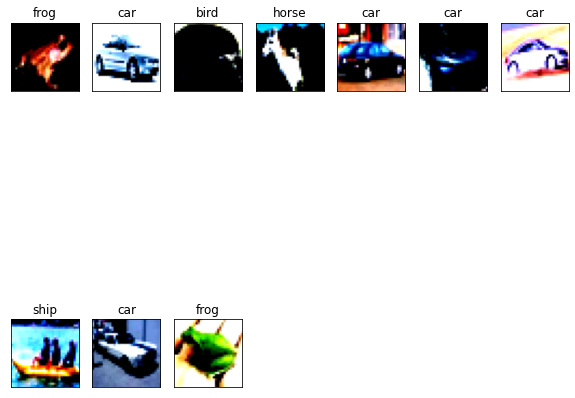

In [28]:
data_iter=iter(train_loader)
images,labels=data_iter.next()
fig=plt.figure(figsize=(15,15))
for i in np.arange(10):
  axes= fig.add_subplot(2,15/2,i+1,xticks=[],yticks=[])
  plt.imshow(np.transpose(images[i],(1,2,0)))
  axes.set_title(classes[labels[i]])



In [29]:

# start = time.time()

# Oprimization Criteria and Optimization method
criterion = nn.CrossEntropyLoss().cuda() if use_gpu else nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet.parameters(), lr=learning_rate, momentum=momentum, nesterov = False)


In [30]:
training_history={'Accuracy':[],'Loss':[]}
validation_history={'Accuracy':[],'Loss':[]}

In [31]:
trainer=create_supervised_trainer(densenet,optimizer,criterion,device=device)
# print(trainer.)
evaluator=create_supervised_evaluator(densenet,
                                      device=device,
                                      metrics={
                                          'Accuracy':Accuracy(),
                                          'Loss':Loss(criterion),
                                          'Confusion_Matrix':ConfusionMatrix(len(classes))
    

})

In [32]:
@trainer.on(Events.ITERATION_COMPLETED)
def log_a_dot(engine):
  print(".",end=" ")

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
  evaluator.run(train_loader)
  metrics=evaluator.state.metrics
  accuracy = metrics['Accuracy']*100
  loss=metrics['Loss']
  training_history['Accuracy'].append(accuracy)
  training_history['Loss'].append(loss)
  print()
  print(f"Training Results - Epoch : {trainer.state.epoch}    Avg accuracy : {accuracy}    Loss: {loss}")



@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
  evaluator.run(valid_loader)
  metrics=evaluator.state.metrics
  accuracy = metrics['Accuracy']*100
  loss=metrics['Loss']
  validation_history['Accuracy'].append(accuracy)
  validation_history['Loss'].append(loss)
  print()
  print(f"Validation Results - Epoch : {trainer.state.epoch}    Avg accuracy : {accuracy}    Loss: {loss}")

In [ ]:
# torch.cuda.empty_cache()

In [34]:
trainer.run(train_loader,max_epochs=nr_epochs)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Training Results - Epoch : 70    Avg accuracy : 100.0    Loss: 0.001216705976985395

Validation Results - Epoch : 70    Avg accuracy : 81.16    Loss: 1.0208903563022613
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Training Results - Epoch : 71    Avg accuracy : 100.0    Loss: 0.0011028874508338048

Validation Results - Epoch : 71    Avg accuracy : 81.10000000000001    Loss: 1.027787103652954
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

State:
	iteration: 19800
	epoch: 100
	epoch_length: 200
	max_epochs: 100
	output: 0.0005072975181974471
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: 12

In [46]:
pwd

'/gdrive/My Drive/Adagrad'

In [47]:
ls

 CMakeLists.txt
 CMakeSamplesTemplate.txt
 cuda_10.2.89_440.33.01_linux.run
 cudnn-10.1-linux-x64-v7.6.5.32.tgz
 densenet.onnx
'Extra_DenseNet_final_da_new__ (1).ipynb'
 Finallyy_Da.ipynb
 nv-tensorrt-repo-ubuntu1804-cuda10.2-trt7.0.0.11-ga-20191216_1-1_amd64.deb
 onnx/
 sampleOnnxMNIST.cpp
 TensorRT-7.0.0.11/
 TensorRT-7.0.0.11.Ubuntu-18.04.x86_64-gnu.cuda-10.2.cudnn7.6.tar.gz


In [49]:
torch.save(densenet,'/gdrive/My Drive/Adagrad/My_model_100.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type DenseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Dense_Block_Transposed. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Transition_Layer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [50]:
load_model=torch.load('/gdrive/My Drive/Adagrad/My_model_100.pth')

Text(0.5, 1.0, 'Validation Loss plot')

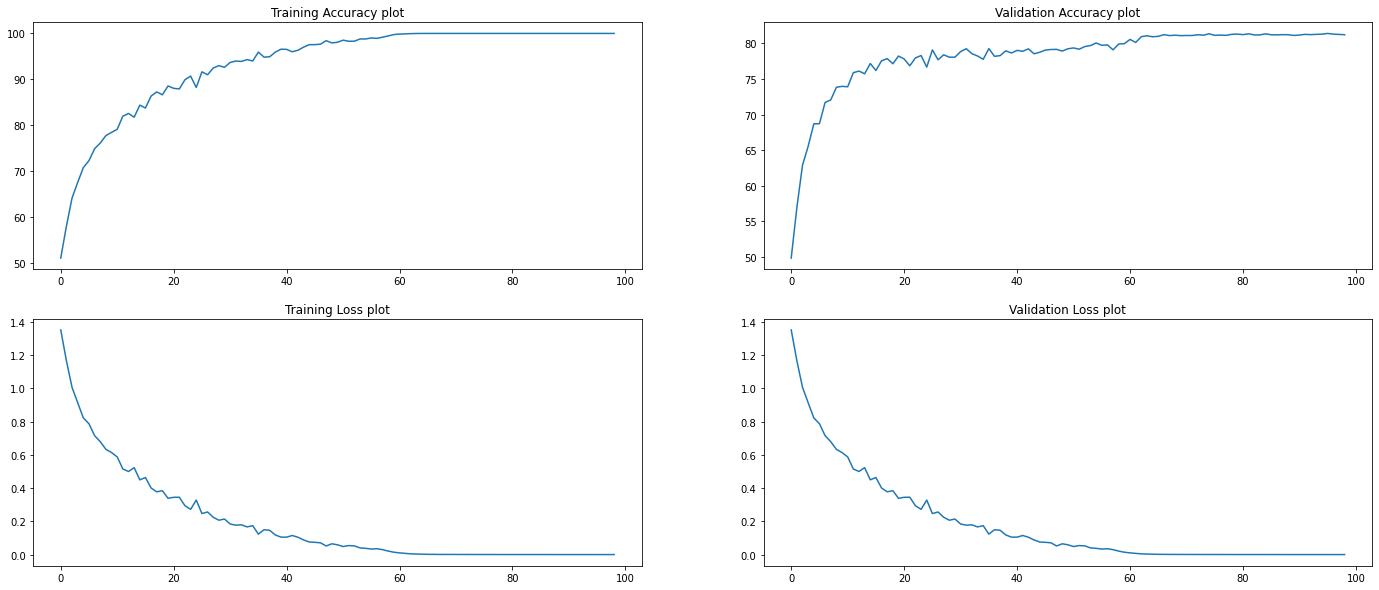

In [51]:
fig,axs=plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(24)
axs[0,0].plot(training_history['Accuracy'])
axs[0,0].set_title('Training Accuracy plot')

axs[0,1].plot(validation_history['Accuracy'])
axs[0,1].set_title('Validation Accuracy plot')

axs[1,0].plot(training_history['Loss'])
axs[1,0].set_title('Training Loss plot')

axs[1,1].plot(training_history['Loss'])
axs[1,1].set_title('Validation Loss plot')


In [53]:
test_loss=0.0
from datetime import datetime,date
class_correct=np.zeros(len(classes))
class_total=np.zeros(len(classes))
load_model.eval()
# print(len(test_loader))
# print(len(test_loader.data))

# i=1
for data,target in test_loader:
    # print(len(data))
    # print(i)
    # for i in range(len(target)):
      # print(i)
    if use_gpu:
      data,target=data.cuda(),target.cuda()

    outputs = load_model(data)
    print(len(outputs))
    loss = criterion(outputs,target)
    test_loss += loss.item()
    not_needed, predicted = torch.max(outputs, 1)
    # loss = criterion(outputs, labels)
    correct_tensor=predicted.eq(target.data.view_as(predicted))
    correct=np.squeeze(correct_tensor.numpy()) if not use_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    if(len(target)==batch_size):#Batch_size da........................................change it here when u shift this to config_file
      # print( time.asctime( time.localtime(time.time()) ))
      print(int(round(time.time() * 1000)))
      # print(datetime.today().microsecond)
      for i in range(64):
        label=target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label]+=1
test_loss/=len(test_loader)
print("Test Loss {:6f}\n ".format(test_loss))

# for i in range(len(classes)):
#   if class_total[i]>0:
#     print("Test Accuracy of {} :{} ({}/{})".format(classes[i],
#                                                 100 * class_correct[i]/class_total[i],
#                                                 np.sum(class_correct[i]),np.sum(class_total[i])))
#   else:
#     print("Test Accuracy of {} :N/A (no eg found)".format(classes[i]))
#     print("Overall Test Accuracy {} ({}/{})".format(100 * class_correct[i]/class_total[i],
#                                                 np.sum(class_correct[i]),np.sum(class_total[i])))


for i in range(len(classes)):

  print("Overall Test Accuracy {:3f} ({}/{})".format(100 * class_correct[i]/class_total[i],
                                                np.sum(class_correct[i]),np.sum(class_total[i])))

200
1592764880508
200
1592764880575
200
1592764880623
200
1592764880690
200
1592764880752
200
1592764880816
200
1592764880885
200
1592764880937
200
1592764880981
200
1592764881045
200
1592764881108
200
1592764881201
200
1592764881258
200
1592764881325
200
1592764881362
200
1592764881395
200
1592764881430
200
1592764881498
200
1592764881557
200
1592764881613
200
1592764881672
200
1592764881722
200
1592764881771
200
1592764881821
200
1592764881872
200
1592764881917
200
1592764881979
200
1592764882030
200
1592764882097
200
1592764882160
200
1592764882256
200
1592764882314
200
1592764882387
200
1592764882432
200
1592764882495
200
1592764882570
200
1592764882639
200
1592764882722
200
1592764882779
200
1592764882853
200
1592764882905
200
1592764882948
200
1592764883000
200
1592764883037
200
1592764883071
200
1592764883102
200
1592764883129
200
1592764883156
200
1592764883182
200
1592764883208
Test Loss 1.139968
 
Overall Test Accuracy 86.390533 (292.0/338.0)
Overall Test Accuracy 90.447761 (

In [54]:
from PIL import Image
from io import BytesIO
import requests

def apply_test_transforms(input_img):
  out=transforms.functional.to_tensor(input_img)
  out=transforms.functional.normalize(out,[0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
  return out

densenet.eval()

def predict(densenet,filepath,show_img=False,url=False):
  if url:
    response=requests.get(filepath)
    img=Image.open(BytesIO(response.content))
  else:
    img=Image.open(filepath)
  if show_img:
    plt.imshow(img)
  image_as_tensor=apply_test_transforms(img)
  single_batch=torch.stack([image_as_tensor])
  if use_gpu:
    single_batch=single_batch.cuda()
  pred = densenet(single_batch)

  _,classnumber= torch.max(pred,1)
  return classes[classnumber]



In [ ]:
# res=predict(densenet,"https://www.google.com/url?sa=i&url=https%https://www.google.com/url?sa=i&url=https%3A%2F%2Fen.wiktionary.org%2Fwiki%2Faeroplane&psig=AOvVaw1e_05Nhz9YWwwcrDoezTwO&ust=1592426148276000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCMC6h-qXh-oCFQAAAAAdAAAAABAD3A%2F%2Fen.wiktionary.org%2Fwiki%2Faeroplane&psig=AOvVaw1e_05Nhz9YWwwcrDoezTwO&ust=1592426148276000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCMC6h-qXh-oCFQAAAAAdAAAAABAD",show_img=True,url=True)

In [ ]:
########################################################################################################################################################################################################################

In [ ]:

# # Training Loop
# print("Start of the Optimization Processs..")
# for epoch in range(nr_epochs):  

#     running_loss = 0.0
#     correct=0.0
#     for i, data in enumerate(train_loader, 0):
#         # print(len(data))
#         # get the inputs
#         inputs, labels = data
#         # print("###############################################################3")
#         # print(len(inputs))
#         # print(len(labels))
#         # print(data)
#         # print(labels)
#         # print("###############################################################3")

#         inputs = Variable(inputs).cuda() 
#         labels = Variable(labels).cuda()
        
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = densenet(inputs)
#         # print(outputs.data)
#         not_needed, predicted = torch.max(outputs.data, 1)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         # print("The loss is {}",format(loss))

#         # print statistics
#         running_loss += loss.item()
#         # correct += (outputs == labels.).float().sum()
#         correct += (predicted == labels).sum().item()
        
        
    
#     print("Epoch {} and Loss is {}".format(epoch,loss.item()))
#     loss_vctr.append(loss.item())
#     accuracy = 100 * correct / len(trainset)
#     print("Accuracy = {}".format(accuracy))
    

# end = time.time() # Time counted in seconds
# print("The total time to train the model on the K80 GPU is : {:.1f} minutes.".format((end - start)/60))

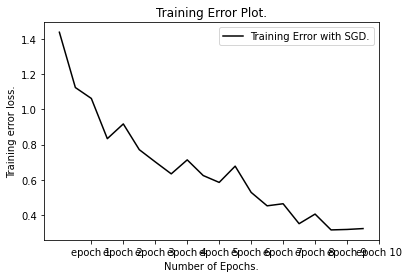

In [ ]:
# from matplotlib import pyplot as plt
# import numpy as np

# x = range(20)
# x_epoch = [z for z in range(1, 21) if z%2 == 0] 
# x_ticks_labels = ['epoch ' + str(x) for x in range(1, 11)]

# plt.figure(2)
# plt.plot(x, loss_vctr ,color = 'k', label = "Training Error with SGD.")
# plt.xticks(x_epoch, x_ticks_labels)
# plt.title("Training Error Plot.")
# plt.ylabel("Training error loss.")
# plt.xlabel("Number of Epochs.")
# plt.legend()

# # plt.savefig("training_plot.png", dpi = 300)  If you want to save your plot, uncomment.
# plt.show()

In [55]:
correct = 0
total = 0

for data in test_loader:
        images, labels = data
        images = Variable(images).cuda()
        outputs = load_model(images)
        _, predicted = torch.max(outputs.cpu().data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 80 %


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [56]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = load_model(images.cuda())
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 92 %
Accuracy of   car : 100 %
Accuracy of  bird : 58 %
Accuracy of   cat : 47 %
Accuracy of  deer : 88 %
Accuracy of   dog : 70 %
Accuracy of  frog : 80 %
Accuracy of horse : 94 %
Accuracy of  ship : 76 %
Accuracy of truck : 88 %


In [57]:
import torch
import torchvision

dummy_input = torch.randn(10, 3, 32, 32, device='cuda')
load_model=load_model.cuda()

# The inputs to the network consist of the flat list of inputs (i.e.
# the values you would pass to the forward() method) followed by the
# flat list of parameters. You can partially specify names, i.e. provide
# a list here shorter than the number of inputs to the model, and we will
# only set that subset of names, starting from the beginning.
input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(5) ]
output_names = [ "output1" ]

torch.onnx.export(load_model, dummy_input, "densenet_new.onnx", verbose=True, input_names=input_names, output_names=output_names)

graph(%actual_input_1 : Float(10, 3, 32, 32),
      %learned_0 : Float(3, 64, 7, 7),
      %learned_1 : Float(64),
      %learned_2 : Float(64),
      %learned_3 : Float(64),
      %learned_4 : Float(64),
      %denseblock1.0.conv1.weight : Float(64, 32, 3, 3),
      %denseblock1.0.conv1.bias : Float(32),
      %denseblock1.0.conv2.weight : Float(32, 32, 3, 3),
      %denseblock1.0.conv2.bias : Float(32),
      %denseblock1.0.conv3.weight : Float(64, 32, 3, 3),
      %denseblock1.0.conv3.bias : Float(32),
      %denseblock1.0.conv4.weight : Float(96, 32, 3, 3),
      %denseblock1.0.conv4.bias : Float(32),
      %denseblock1.0.conv5.weight : Float(128, 32, 3, 3),
      %denseblock1.0.conv5.bias : Float(32),
      %denseblock2.0.bn.weight : Float(128),
      %denseblock2.0.bn.bias : Float(128),
      %denseblock2.0.bn.running_mean : Float(128),
      %denseblock2.0.bn.running_var : Float(128),
      %denseblock2.0.conv1.weight : Float(128, 32, 3, 3),
      %denseblock2.0.conv1.bias : Flo

In [58]:
!pip install onnx

     |████████████████████████████████| 7.4MB 4.8MB/s 


In [59]:
import onnx

# Load the ONNX model
model = onnx.load("densenet_new.onnx")

# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
onnx.helper.printable_graph(model.graph)

"graph torch-jit-export (\n  %actual_input_1[FLOAT, 10x3x32x32]\n) initializers (\n  %bn.bias[FLOAT, 64]\n  %bn.running_mean[FLOAT, 64]\n  %bn.running_var[FLOAT, 64]\n  %bn.weight[FLOAT, 64]\n  %classifier.bias[FLOAT, 10]\n  %classifier.weight[FLOAT, 10x512]\n  %denseblock1.0.conv1.bias[FLOAT, 32]\n  %denseblock1.0.conv1.weight[FLOAT, 64x32x3x3]\n  %denseblock1.0.conv2.bias[FLOAT, 32]\n  %denseblock1.0.conv2.weight[FLOAT, 32x32x3x3]\n  %denseblock1.0.conv3.bias[FLOAT, 32]\n  %denseblock1.0.conv3.weight[FLOAT, 64x32x3x3]\n  %denseblock1.0.conv4.bias[FLOAT, 32]\n  %denseblock1.0.conv4.weight[FLOAT, 96x32x3x3]\n  %denseblock1.0.conv5.bias[FLOAT, 32]\n  %denseblock1.0.conv5.weight[FLOAT, 128x32x3x3]\n  %denseblock2.0.bn.bias[FLOAT, 128]\n  %denseblock2.0.bn.running_mean[FLOAT, 128]\n  %denseblock2.0.bn.running_var[FLOAT, 128]\n  %denseblock2.0.bn.weight[FLOAT, 128]\n  %denseblock2.0.conv1.bias[FLOAT, 32]\n  %denseblock2.0.conv1.weight[FLOAT, 128x32x3x3]\n  %denseblock2.0.conv2.bias[FLOAT, 